# Tutorial 2- Optimal Control for Continuous State

Please execute the cell below to initialize the notebook environment.

In [ ]:
import numpy as np                  # import numpy
import scipy                        # import scipy
import random                       # import basic random number generator functions
from scipy.linalg import inv        # import matrix inversion
import matplotlib.pyplot as plt     # import matplotlib

---

## Tutorial objectives

In this tutorial, we will implement the linear qudratic regulator (LQR) and linear quadratic gaussian (LQG) controllers for the 1D case.

## INSERT TUTORIAL VIDEO 2a

### Linear Dynamical System with control input

In general, a linear discrete-time system with noise has the dynamic:

\begin{equation*}
s_{t+1} = Ds_t + Ba_t + w_t 
\end{equation*}

with 

$s_t$: state at time $t$ 

$a_t$: control at time $t$

$w_t$: gaussian noise at time $t$

$D$ and $B$: parameters of the linear dynamical system  

For simplicity, we will consider the 1D case, where the matrices reduce to scalars, and the states, control and noise are one-dimensional as well. Specifically, $D$ and $B$ are scalars.

In open-loop control, $a_t$ is not a function of $s_t$. In closed-loop linear control, $a_t$ is the control gain $L_t$ multiplied by $s_t$, i.e. $a_t=L_t s_t$.

---
##### Class for LDS

In [ ]:
class LDS:
    def __init__(self, T, ini_state, noise_var, goal):
        self.T = T
        self.goal = goal
        self.ini_state = ini_state
        self.noise_var = noise_var
    
    
    def dynamics(self, D, B):

        s = np.zeros(self.T) # states initialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        for t in range(self.T - 1):
            ###################################################################
            ## Insert your code here to fill with the state dynamics equation
            ## without any control input
            ## s[t+1] = ?
            ################################################################### 
            s[t+1] = 0 # replace 0 with your answer

        return s

    # to_remove solution
    def dynamics_solution(self, D, B):

        s = np.zeros(self.T) # states initialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        for t in range(self.T - 1):
            s[t + 1] = D * s[t] + noise[t]
        
        return s

    def dynamics_openloop(self, D, B, a):

        s = np.zeros(self.T) # states initialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        for t in range(self.T - 1):
            ###################################################################
            ## Insert your code here to fill with the state dynamics equation 
            ## with open-loop control input a[t]
            ## s[t+1] = ?
            ################################################################### 
            s[t+1] = 0 # replace 0 with your answer

        return s

    # to_remove solution
    def dynamics_openloop_solution(self, D, B, a):

        s = np.zeros(self.T) # states initialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        for t in range(self.T - 1):
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        
        return s

    def dynamics_closedloop(self, D, B, L):

        s = np.zeros(self.T) # states initialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        a = np.zeros(self.T)

        for t in range(self.T - 1):
            ###################################################################
            ## Insert your code here to fill with the state dynamics equation 
            ## with closed-loop control input as a function of control gain L.
            ## a[t] = ?
            ## s[t+1] = ?
            ################################################################### 
            a[t] = 0 # replace 0 with your answer
            s[t+1] = 0 # replace 0 with your answer
            
        return s, a
        
    # to_remove solution    
    def dynamics_closedloop_solution(self, D, B, L):

        s = np.zeros(self.T) # states initialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        a = np.zeros(self.T - 1)

        for t in range(self.T - 1):
            a[t] =  L[t] * s[t] 
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        
        return s, a   


In [ ]:
def plot_vs_time(s,slabel,color,goal=None):        
    plt.plot(s, color, label = slabel)
    if goal is not None:
      plt.plot(goal, 'm', label = 'goal')
    plt.xlabel("time", fontsize =14)
    plt.legend(loc="upper right")

---
### Exercise 1: Explore no control vs. open-loop control vs. closed-loop control
* No control: simulate just the state dynamics without any control input. What if the system is unstable (D>1)?
* Open-loop: Design an open-loop control input while knowing the initial state, to reach the goal in one time step.
* Closed-loop: Design a closed-loop control input to reach the goal in one time step. Notice that you are effectively changing the system dynamics.
* Closed-loop: Set the control gain to be a constant over time. You can play with this parameter to compare the dynamics and MSE. Find the control gain that gives you the minimum MSE.

In [ ]:
## Play around with these parameters and see the effect on the state.
D = 0.95  # state parameter 
B = 2   # control parameter
T = 20  # time horizon
ini_state = 2      # initial state
noise_var = 0.1   # process noise
goal = np.zeros(T)

In [ ]:
lds = LDS(T, ini_state, noise_var, goal)
# No control
s_no_control=lds.dynamics_solution(D,B)
# Open loop control
a = np.append(-1,np.zeros(T-1))
s_open_loop=lds.dynamics_openloop_solution(D,B,a)
# Closed loop control
L =  - np.ones(T) * 0.3
s_closed_loop, a_closed_loop = lds.dynamics_closedloop_solution(D, B, L)

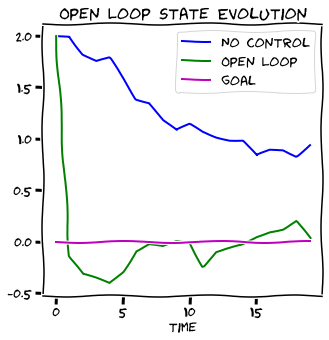

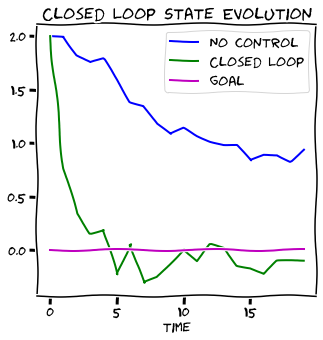

In [ ]:
with plt.xkcd():
    fig = plt.figure(figsize=(5, 5))
    plot_vs_time(s_no_control,'No control','b')
    plot_vs_time(s_open_loop,'Open Loop','g', goal)
    plt.title('Open Loop State Evolution')
    plt.show()

with plt.xkcd():
    fig = plt.figure(figsize=(5, 5))
    plot_vs_time(s_no_control,'No control','b')
    plot_vs_time(s_closed_loop,'Closed Loop','g',goal)
    plt.title('Closed Loop State Evolution')
    plt.show()


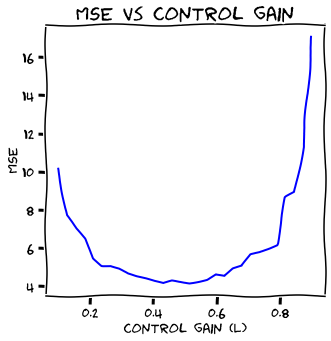

In [ ]:
control_gain_array = np.linspace(0.1,0.9,30)
mse_array = np.zeros(control_gain_array.shape)
for i in range(len(control_gain_array)):
    target = np.zeros(T)
    lds = LDS(T, ini_state, noise_var, target)
    L =  -np.ones(T) * control_gain_array[i]
    s, a = lds.dynamics_closedloop_solution(D, B, L)
    mse_array[i] = np.sum(s ** 2)

with plt.xkcd():
  fig = plt.figure(figsize=(5, 5))
  plt.plot(control_gain_array, mse_array, 'b')
  plt.xlabel("control gain (L)", fontsize =14)
  plt.ylabel("MSE" , fontsize =14)
  plt.title("MSE vs control gain", fontsize =20)
  plt.show()

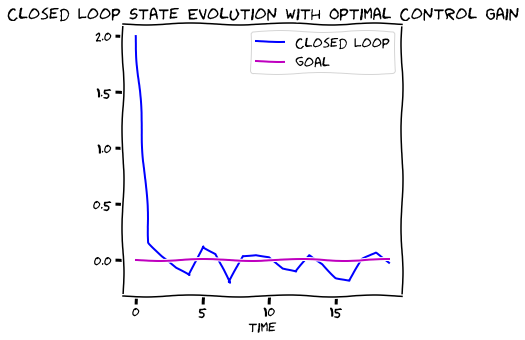

In [ ]:
min_error_controlgain=control_gain_array[np.argmin(mse_array)]
# Closed loop control
L = -np.ones(T) * min_error_controlgain
s_closed_loop, a_closed_loop = lds.dynamics_closedloop_solution(D, B, L)
with plt.xkcd():
    fig = plt.figure(figsize=(5, 5))
    plot_vs_time(s_closed_loop,'Closed Loop','b',goal)
    plt.title('Closed Loop State Evolution with Optimal Control Gain')
    plt.show()

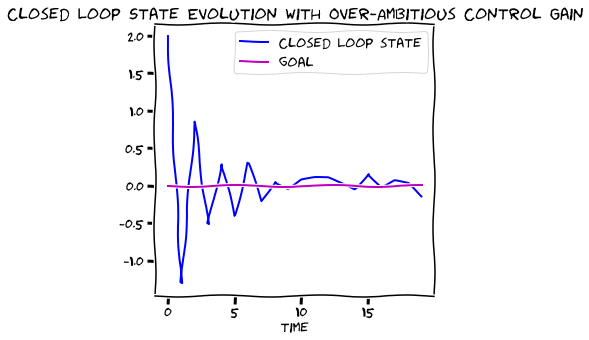

In [ ]:
# Over-ambitious control gain
################################################################################
## Insert your code here to:
##      create a constant control gain that causes oscillations in the state evolution
################################################################################
# L = -np.ones(T) * (min_error_controlgain + ??)

# to_remove solution
L = -np.ones(T) * (min_error_controlgain+0.4)

s_closed_loop, a_closed_loop = lds.dynamics_closedloop_solution(D, B, L)
with plt.xkcd():
    fig = plt.figure(figsize=(5, 5))
    plot_vs_time(s_closed_loop,'Closed Loop state','b',goal)
    plt.title('Closed Loop State Evolution with Over-Ambitious Control Gain')
    plt.show()

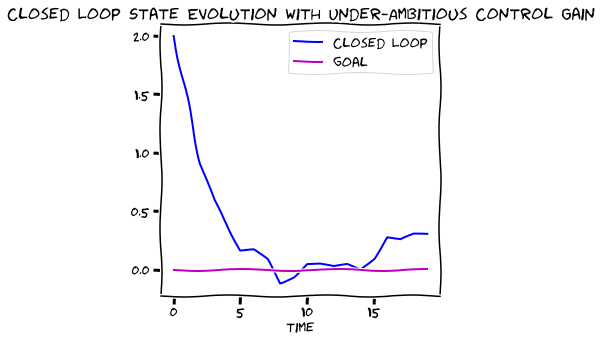

In [ ]:
# Under-ambitious control gain
################################################################################
## Insert your code here to:
##      create a constant control gain that causes a slowly decaying state evolution
################################################################################
# L = -np.ones(T) * (min_error_controlgain - ??)

# to remove solution
L = -np.ones(T) * (min_error_controlgain-0.3)

s_closed_loop, a_closed_loop = lds.dynamics_closedloop_solution(D, B, L)
with plt.xkcd():
    fig = plt.figure(figsize=(5, 5))
    plot_vs_time(s_closed_loop,'Closed Loop','b',goal)
    plt.title('Closed Loop State Evolution with Under-Ambitious Control Gain')
    plt.show()

## Designing an optimal control input using LQR

## INSERT TUTORIAL VIDEO 2b

---

## Quadratic cost function 

In the LQR problem,  a quadratic cost function is defined as: 

\begin{eqnarray}
J({\bf s},{\bf a}) &=& J_{state}({\bf s}) + \rho J_{control}({\bf a}) \\
 &=& \sum_{t = 0}^{T} (s_{t}-g)^2 + \rho \sum_{t=0}^{T-1}a_{t}^2
\end{eqnarray}

where $\rho$ is the weight on the control effort cost, as compared to the cost of not being at the goal. Here, ${\bf a} = \{a_t\}_{t=0}^{T-1}$, ${\bf s} = \{s_t\}_{t=0}^{T}$

The goal of the LQR problem is to find control ${\bf a}$ such that $J({\bf s},{\bf a})$ is minimized. The goal is then to find the control gain at each time point, i.e.,

$$ \text{argmin} _{\{L_t\}_{t=0}^{T-1}}  J({\bf s},{\bf a}) $$ 

where $a_t = L_t s_t$.

---

## Solving LQR with Dynamic Programming

The solution of LQR can be obtained via Dynamic Programming as follows:
1. set $P_T = 1$
2. for $t = T ,...,1$,

    $P_{t-1}  = 1 + D^2P_t - \frac{D^2B^2P_t^2}{R+B^2P_t}$

3. update the control gain
   
   for $t = T ,...,1$,

    $L_{t-1}  = -\frac{DBP_t}{R+B^2P_t}$

4. optimal gain at time $t$ is: $a_t = L_tx_t$


---
##### Helper class for LQR

In [ ]:
class LQR(LDS):
    def __init__(self, T, ini_state, noise_var, goal):
        super().__init__(T, ini_state, noise_var, goal)
    
    def control_gain_LQR(self, D, B, rho):
        P = np.zeros(self.T) # Riccati updates
        P[-1] = 1  
        
        L = np.zeros(self.T-1) # control gain 
        
        for t in range(self.T-1):
            P[self.T - t - 2] = (1 + 
                            P[self.T - t - 1] * D **2 - 
                            D * P[self.T - t - 1] * B / (
                                rho + P[self.T - t - 1] * B) * B ** 2 * P[self.T - t - 1] * D)

            L[self.T - t - 2] =  -(1 / (rho + P[self.T - t - 1] * B ** 2) * B * P[self.T - t - 1] * D) 
        
        return L

    def calculate_J_state(self,s):
        ###################################################################
        ## Insert your code here to calculate J_state(s).
        ## J_state = ?
        ################################################################### 
        J_state = 0 # Replace 0 with your answer
        return J_state

    # to remove solution
    def calculate_J_state_solution(self,s):
        J_state = np.sum((s-self.goal) ** 2)
        return J_state      
      
    def calculate_J_control(self,a):
        ###################################################################
        ## Insert your code here to calculate J_control(s).
        ## J_control = ?
        ################################################################### 
        J_control = 0 # Replace 0 with your answer
        return J_control

    # to remove solution
    def calculate_J_control_solution(self,a):
        J_control = np.sum(a ** 2) 
        return J_control
                

### Exercise 2: LQR to the origin 

In this exercise, we will design an LQR control to track a goal at 0
* Pick $\rho$ with same cost and control gain as Exercise 1.
* Pick large $\rho$ and see the effect on the action.
* For different values of $\rho$, solve for the LQR controller, and plot the trajectory of states. 
* For different values of $\rho$, plot the state cost vs. the control cost to visualize the tradeoff between the two costs

In [ ]:
## Play around with rho and see the effect on the state and action.
## For which rho is the cost equal to the optimal cost found in Exercise 1?
## Try increasing the rho to 2. What do you notice?
D = 0.9  # state parameter 
B = 2   # control parameter
rho = 1
T = 20  # time horizon
ini_state = 2      # initial state
noise_var = 0.1   # process noise
goal = np.zeros(T)

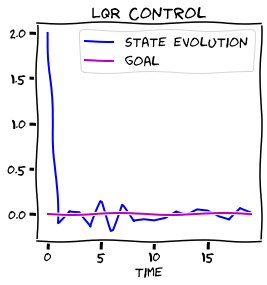

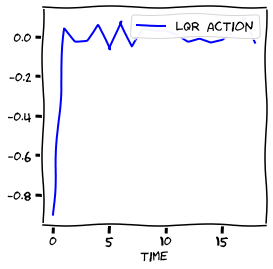

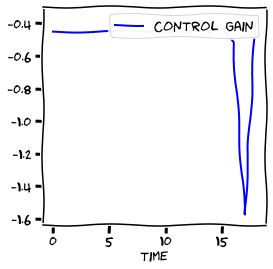

In [ ]:
lqr = LQR(T, ini_state, noise_var, goal)
L = lqr.control_gain_LQR(D, B, rho)
s_lqr, a_lqr = lqr.dynamics_closedloop_solution(D, B, L)

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4))
    plot_vs_time(s_lqr,'State evolution','b',goal)
    plt.title('LQR Control')
    plt.show()
    fig = plt.figure(figsize=(4, 4))
    plot_vs_time(a_lqr,'LQR Action','b')
    plt.show()
    fig = plt.figure(figsize=(4, 4))
    plot_vs_time(L,'Control Gain','b')
    plt.show()


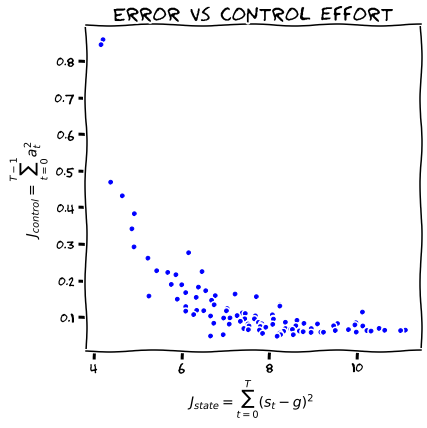

This curve shows the tradeoff between the two costs using the optimal control input. We cannot reach the errors below this curve.


In [ ]:
# Provide the code for J_state and J_control in the above function. 
# We will then plot them against each other for varying values of rho

rho_array = np.linspace(0.2,40,100)
J_state = np.zeros(rho_array.shape)
J_control = np.zeros(rho_array.shape)
for i in np.arange(len(rho_array)):
    target = np.zeros(T)
    lqr = LQR(T, ini_state, noise_var, target)
    L = lqr.control_gain_LQR(D, B, rho_array[i])
    s_lqr, a_lqr = lqr.dynamics_closedloop_solution(D, B, L)
    J_state[i] = lqr.calculate_J_state_solution(s_lqr) ## Code this up.
    J_control[i] = lqr.calculate_J_control_solution(a_lqr) ## Code this up.

with plt.xkcd():
    fig = plt.figure(figsize=(6, 6))
    plt.plot(J_state, J_control, '.b')
    plt.xlabel("$J_{state} = \sum_{t = 0}^{T} (s_{t}-g)^2$", fontsize =14)
    plt.ylabel("$J_{control} = \sum_{t=0}^{T-1}a_{t}^2$" , fontsize =14)
    plt.title("Error vs control effort", fontsize =20)
    plt.show()
print('This curve shows the tradeoff between the two costs using the optimal control input. We cannot reach the errors below this curve.')

## LQR for tracking a time-varying goal

## INSERT TUTORIAL VIDEO 2c

When the target state, denoted as $g_t$, is not zero state, the cost function becomes
$$ J({\bf a}) = \sum_{t = 0}^{T} (s_{t}- g_t) ^2 + \rho \sum_{t=0}^{T-1}(a_{t}-\bar a_t)^2$$
Here, $\bar a_t$ is the desired action based on the reference trajectory.

We will first consider a sinusoidal trajectory to track: $g_t=\sin(2\pi \Omega t/T)$, with $\Omega=5$.

---
##### Helper class for LQR control to desired time-varying goal

In [ ]:
class LQR_tracking(LQR):
    def __init__(self, T, ini_state, noise_var, goal):
        super().__init__(T, ini_state, noise_var, goal)

    def dynamics_tracking(self, D, B, L):
        
        s = np.zeros(self.T) # states intialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        a = np.zeros(self.T) # control intialization
        a_bar = np.zeros(self.T)
        for t in range(self.T - 1):
            a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
            a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        
        return s, a

### Exercise 3: LQR control to desired time-varying goal
In this excercise, we will design an LQR controller to track a sinusoid function. 

* In the following code, first generate the target trajectory of sinusoid.

* Use the provided plotting functions to plot the states over time, the control over time.

* Play around with the value of $\rho$.

In [ ]:
## Play around with rho and see the effect on the state.
D = 0.9  # state parameter 
B = 2   # control parameter
rho = 2
T = 100  # time horizon
ini_state = 2      # initial state
noise_var = 0.1   # process noise

In [ ]:
## Code up the goal
################################################################################
## Insert your code here to:
##      create a time varying goal with a sinusoidal profile, with Omega=5
################################################################################
# goal = ?

# to remove solution
goal = np.sin(np.arange(T) * 2 * np.pi * 5 /T) 


lqr_sine= LQR_tracking(T, ini_state, noise_var, goal)
L = lqr_sine.control_gain_LQR(D, B, rho)
s_lqr_sine, a_lqr_sine = lqr_sine.dynamics_tracking(D, B, L)

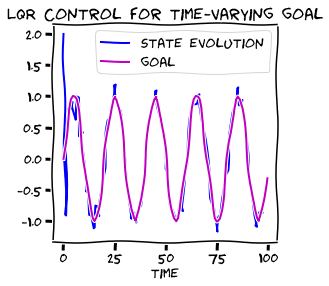

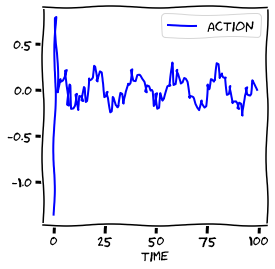

In [ ]:
with plt.xkcd():
    fig = plt.figure(figsize=(4, 4))
    plot_vs_time(s_lqr_sine,'State evolution','b',goal)
    plt.title('LQR Control for time-varying goal')
    plt.show()
    fig = plt.figure(figsize=(4, 4))
    plot_vs_time(a_lqr_sine,'Action','b')
    plt.show()

## Exercise 4: LQG control of uncertain state with finite time horizon


## INSERT TUTORIAL VIDEO 2d

In the previous examples, a target state is provided. However, in practice, one cannot get access to all the state variables. Then there comes the questions: Can we recover the state variables through the measurable information? 

From yesterday's lecture, it is known that the stataes $\hat{x}$ can be estimated with __Kalman filter__. Due to the separation principle, we can replace the control law in LQR, i.e.

$$a_t = - L_t \hat x_t$$

with the estimated states. 

##### Helper class for Kalman Filter

In [ ]:
class MyKalmanFilter():
    def __init__(self, n_dim_state, n_dim_obs, transition_matrices, transition_covariance, observation_matrices,
                observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state 
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = transition_matrices #np.eye(n_dim_state)
        self.transition_covariance = transition_covariance #np.eye(n_dim_state) 
        self.observation_matrices = observation_matrices #np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = observation_covariance #np.eye(n_dim_obs)
        self.initial_state_mean = initial_state_mean #np.zeros(n_dim_state)
        self.initial_state_covariance = initial_state_covariance #np.eye(n_dim_state)
        
        self.control_matrices = control_matrices #np.eye(n_dim_state)
        
    def sample(self, n_timesteps, control_gain, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        # set initial states and seed
        if initial_state is None:
            initial_state = self.initial_state_mean
        if random_seed is not None:
            np.random.seed(random_seed)

        ################
        ##### TODO #####
        ################
        # produce samples
        latent_state = []
        observed_state = []
        current_latent_state = initial_state
        for t in range(n_timesteps):
            
            # for the first latent state is set to the initial state
            if t == 0:
                latent_state.append(current_latent_state)
            # otherwise use transition_matrices and transition_covariance to calculate next latent state
            else:
                #print(current_latent_state)
                ###################LQG#################################
                current_control = - control_gain[t] * current_latent_state
                    
                ###################LQG#################################
                latent_state.append(np.dot(self.transition_matrices, current_latent_state) +
                                    np.dot(self.control_matrices, current_control) + 
                                    np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                                  self.transition_covariance))
                current_latent_state = latent_state[-1]
                
                
                
            # use observation_matrices and observation_covariance to calculate next observed state
            observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

        #latent_state = np.zeros([n_timesteps, self.n_dim_state])
        #observed_state = np.zeros([n_timesteps, self.n_dim_obs])
        return np.array(latent_state), np.array(observed_state)
    

    def filter(self, X, control_gain, use_myfilter=True):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """

        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim == self.n_dim_obs

        # create holders for outputs
        filtered_state_means = np.zeros([n_example, self.n_dim_state])
        filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])

        #############################
        # TODO: implement filtering #
        #############################
        if use_myfilter:
            # the first state mean and state covar is the initial expectation
            filtered_state_means[0] = self.initial_state_mean
            filtered_state_covariances[0] = self.initial_state_covariance

            # initialize internal variables
            current_state_mean = self.initial_state_mean.copy()
            current_state_covar = self.initial_state_covariance.copy()
            self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
            for i in range(1, n_example):
                current_observed_data = X[i, :]
                # run a single step forward filter
                # prediction step
                current_control = - control_gain[i - 1] * current_state_mean
                
                ###################LQG#################################
                predicted_state_mean = np.dot(self.transition_matrices, current_state_mean
                                             ) + np.dot(self.control_matrices, current_control)
                predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                                np.transpose(self.transition_matrices)) + self.transition_covariance
                # observation step
                innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
                innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                                  np.transpose(self.observation_matrices)) + self.observation_covariance
                # update step
        
     
                kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                        np.linalg.inv(innovation_covariance))
                current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation) 
                current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                                 np.matmul(kalman_gain, self.observation_matrices)),
                                                predicted_state_cov)
                # populate holders
                filtered_state_means[i, :] = current_state_mean
                filtered_state_covariances[i, :, :] = current_state_covar
                self.p_n_list[i, :, :] = predicted_state_cov
                # self.p_n_list[i-1, :, :] = predicted_state_cov
            # new
            # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
            #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#         #################################################################################

        return filtered_state_means, filtered_state_covariances

    def filter_com(self, n_timesteps, control_gain, use_myfilter=True):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """

        # validate inputs
        #n_example, observed_dim = X.shape
        #assert observed_dim == self.n_dim_obs
        
        n_example = n_timesteps
        observed_dim = self.n_dim_obs
        latent_state = []
        observed_state = []
        control = []
        
        current_latent_state = self.initial_state_mean #initial_state
        control.append(self.initial_state_mean)
        latent_state.append(current_latent_state)
        observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))



        # create holders for outputs
        filtered_state_means = np.zeros([n_example, self.n_dim_state])
        filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])

        #############################
        # TODO: implement filtering #
        #############################
        if use_myfilter:
            # the first state mean and state covar is the initial expectation
            filtered_state_means[0] = self.initial_state_mean
            filtered_state_covariances[0] = self.initial_state_covariance

            # initialize internal variables
            current_state_mean = self.initial_state_mean.copy()
            current_state_covar = self.initial_state_covariance.copy()
            self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
            
            for i in range(1, n_example - 1):
                #print(current_latent_state)
                
                ###################LQG#################################
                current_control =  control_gain[i] * current_state_mean
                control.append(current_control)    
                ###################LQG#################################
                
                latent_state.append(np.dot(self.transition_matrices, current_latent_state) +
                                    np.dot(self.control_matrices, current_control) + 
                                    np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                                  self.transition_covariance))
                current_latent_state = latent_state[-1]
                
                                
                # use observation_matrices and observation_covariance to calculate next observed state
                observed_state.append(np.dot(self.observation_matrices, current_latent_state
                                            ) + np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

                observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

                
                current_observed_data = observed_state[-1]
                # run a single step forward filter
                # prediction step
                
                ###################LQG#################################
                predicted_state_mean = np.dot(self.transition_matrices, current_state_mean
                                             ) + np.dot(self.control_matrices, current_control)
                predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                                np.transpose(self.transition_matrices)) + self.transition_covariance
                # observation step
                innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
                innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                                  np.transpose(self.observation_matrices)) + self.observation_covariance
                # update step
        
     
                kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                        np.linalg.inv(innovation_covariance))
                current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation) 
                current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                                 np.matmul(kalman_gain, self.observation_matrices)),
                                                predicted_state_cov)
                # populate holders
                filtered_state_means[i, :] = current_state_mean
                filtered_state_covariances[i, :, :] = current_state_covar
                self.p_n_list[i, :, :] = predicted_state_cov
                # self.p_n_list[i-1, :, :] = predicted_state_cov
            # new
            # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
            #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#         #################################################################################
        
        filtered_state_means = np.squeeze(np.array(filtered_state_means))
        filtered_state_covariances = np.squeeze(np.array(filtered_state_covariances))
        latent_state = np.squeeze(np.array(latent_state))
        observed_state = np.squeeze(np.array(observed_state))
        control = np.squeeze(np.array(control))
        
        
        return filtered_state_means, filtered_state_covariances, latent_state, observed_state, control






### Implement Kalman filter

In [ ]:
n_dim_state = 1
n_dim_obs = 1
n_timesteps = 20

transition_matrices = np.eye(n_dim_state)*.9
transition_covariance = np.eye(n_dim_obs) * .1
observation_matrices = np.eye(n_dim_state)
observation_covariance = np.eye(n_dim_obs) * 0.00001
initial_state_mean = np.zeros(n_dim_state)
initial_state_covariance = np.eye(n_dim_state)*.01
control_matrices = np.eye(n_dim_state)

In [ ]:
my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, 
                       transition_matrices, transition_covariance, observation_matrices,
                       observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

In [ ]:
control_gain = - np.ones(n_timesteps) * .87
filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = my_kf.filter_com(n_timesteps, control_gain)

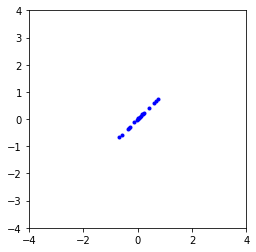

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(latent,filtered_state_means_impl[:-1], 'b.')
ax.set_aspect('equal')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
plt.show()

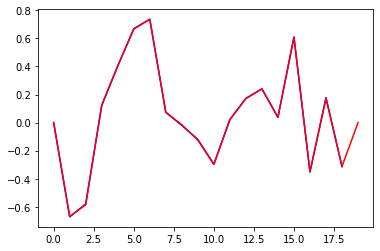

In [ ]:
plt.plot(latent, 'b')
plt.plot(filtered_state_means_impl, 'r')

In [ ]:
class LQG(MyKalmanFilter, LQR):
    def __init__(self, T, target, n_dim_state, n_dim_obs, 
                 transition_matrices, transition_covariance, observation_matrices,
                 observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
        MyKalmanFilter.__init__(self,n_dim_state, n_dim_obs, 
                                transition_matrices, transition_covariance, 
                                observation_matrices,observation_covariance, 
                                initial_state_mean, initial_state_covariance, control_matrices)
        LQR.__init__(self,T, initial_state_mean, transition_covariance, target)   

In [ ]:
goal = np.zeros(n_timesteps - 1)
Q = np.eye(n_dim_state)   # cost of state
R = rho * np.eye(n_dim_obs)  # cost of control

rho  = 1

lqg = LQG(n_timesteps, goal, n_dim_state, n_dim_obs, 
             transition_matrices, transition_covariance, observation_matrices,
             observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

In [ ]:
control_gain_lqg = lqg.control_gain_LQR(transition_matrices, control_matrices, rho)
filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
    n_timesteps, control_gain_lqg)

In [ ]:
lqg_cost = lqg.calculate_J_state_solution(latent)  + lqg.calculate_J_control_solution(control)
#lqg_cost = lqg.cost(latent, control, Q, R)
lqg_cost

2.2887981073147725

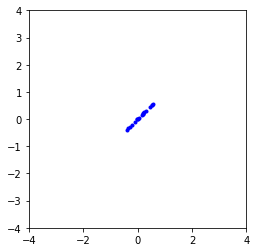

In [ ]:
# latent, data = lqg.sample(n_timesteps, L, initial_state=my_kf.initial_state_mean)
# filtered_state_means_impl, filtered_state_covariances_impl = lqg.filter(data, L)
fig, ax = plt.subplots(1, 1)
ax.plot(latent,filtered_state_means_impl[:-1], 'b.')
ax.set_aspect('equal')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
plt.show()

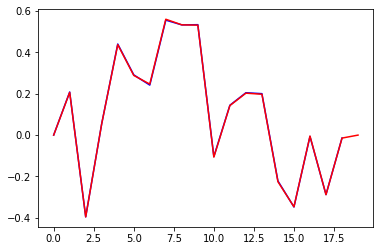

In [ ]:
plt.plot(latent, 'b')
plt.plot(filtered_state_means_impl, 'r')

In [ ]:
lqg_cost_array = [] 
cost_array_N = []
n_iter = 10

#fig, ax = plt.subplots(1, figsize = (6, 6))
for i in range(n_iter):
    control_gain_array = np.linspace(0.1,1.5,20)
    cost_array = np.zeros(control_gain_array.shape)
    for i in range(len(control_gain_array)):
        control_gain = - np.ones(n_timesteps) * control_gain_array[i]
        filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
            n_timesteps, control_gain)
        cost_array[i] = lqg.calculate_J_state_solution(latent)  + lqg.calculate_J_control_solution(control)
    cost_array_N.append(cost_array)
        
    control_gain_lqg = lqg.control_gain_LQR(transition_matrices, control_matrices, rho)
    filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
        n_timesteps, control_gain_lqg)
    lqg_cost = lqg.calculate_J_state_solution(latent)  + lqg.calculate_J_control_solution(control)
    lqg_cost_array.append(lqg_cost)
    
cost_array_mean = np.mean(np.array(cost_array_N), axis = 0)

cost_array_std = np.std(np.array(cost_array_N), axis = 0)

lqg_cost_mean = np.mean(np.array(lqg_cost_array))
lqg_cost_std = np.std(np.array(lqg_cost_array))

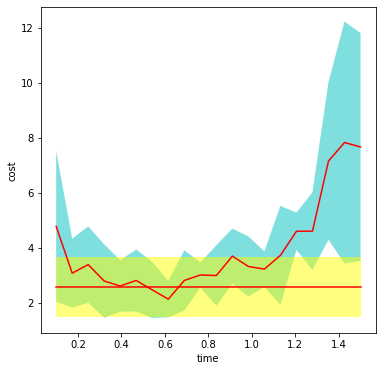

In [ ]:
fig, ax = plt.subplots(1, figsize = (6, 6))

ax.plot(control_gain_array, cost_array_mean, 'r-')
ax.fill_between(control_gain_array, cost_array_mean+cost_array_std, 
                cost_array_mean-cost_array_std, facecolor='c', alpha=0.5)


ax.plot(control_gain_array, np.ones(control_gain_array.shape) * lqg_cost_mean, 'r-')
ax.fill_between(control_gain_array, lqg_cost_mean+lqg_cost_std, 
                lqg_cost_mean-lqg_cost_std, facecolor='yellow', alpha=0.5)

ax.set_xlabel('time')
ax.set_ylabel('cost')

plt.show()